<a href="https://colab.research.google.com/github/AJ-21cm/AJ-21cm/blob/main/Analysis_on_different_large_cities_of_India.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import networkx as nx
import numpy as np
from scipy.optimize import curve_fit
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import osmnx as ox

In [ ]:
def GT_model_graph(l,t):
    l=l
    w=2*l+1
    G=nx.grid_2d_graph(w,w,periodic=False, create_using=None)
    #nx.draw(G,with_labels=True)
    G_=nx.convert_node_labels_to_integers(G)
    x=[l,l*(w+1)-l,l*(w+1)+l,l*2*(w+1)-l]
    edge_conn=[(x[0],100*x[0]),(x[1],100*x[1]),(x[2],100*x[2]),(x[3],100*x[3])]
    edge_tree=[]
    for k in x:
      h=k*100
      for i in range(t+1):
          for j in range(i+1,i+3):
              edge_tree.append((h+i,h+i+j))
    edge_list=[*edge_tree,*edge_conn]
    tree_nodes=len(edge_list)
    G_.add_edges_from(edge_list)
    G_1=nx.convert_node_labels_to_integers(G_)
    return G_1,tree_nodes

In [ ]:
GT,tnodes=GT_model_graph(l=7,t=6)

In [ ]:
def mat_cont_same_deg_nodes(G_):
    nodes=G_.number_of_nodes()
    #Dict_deg={v:d//2 for v,d in G_.degree()}
    #set_=set(d//2 for v,d in G_.degree())
    Dict_deg={v:d for v,d in G_.degree()}
    set_=set(d for v,d in G_.degree())
    uniq_deg=list(set_)
    mat=-np.ones((max(set_)+1,nodes))
    for j in range(len(uniq_deg)):
      c=0
      deg=uniq_deg[j]
      for i in range(nodes):
          k=Dict_deg.get(i)
          if k==deg and k!=0:
             mat[deg,c]=i
             c=c+1
    return mat
#Degree correlation function calculation
def deg_correlation_funct(G_):
    nodes=G_.number_of_nodes()
    corr_fun=np.zeros(nodes)
    #Dict_deg={v:d//2 for v,d in G_.degree()}
    Dict_deg={v:d for v,d in G_.degree()}
    for i in range(nodes):
      s=0
      k_i=Dict_deg[i]
      neig=G_.adj[i]
      neig_list=[str(i) for i in neig.keys()]
      k_arry=np.array(neig_list)
      for j in k_arry:
        s+=Dict_deg[int(j)]
      corr_fun[i]=s/k_i
    return corr_fun
#Average correaltion function computation
def average_degree_correlation_fun(corr_fun,G_,mat):
    corr_fun_=[]
    #Dict_deg={v:d//2 for v,d in G_.degree()}
    Dict_deg={v:d for v,d in G_.degree()}
    max_deg=max(Dict_deg.values())
    for i in range(max_deg+1):
       sum=0
       count=0
       for j in mat[i,::]:
           if j==-1:
             break
           else:
             count+=1
             sum+=corr_fun[int(j)]
       if count!=0:
        corr_fun_.append([i,sum/count])
    corr_fun_=np.array(corr_fun_)
    return corr_fun_
def objective(a,b,x):
    return (a*x+b)
# fit curve
def Curve_fitting_plotting(avg_Dcorr_fun,string_title):
    a_=avg_Dcorr_fun
    x_values=np.log(a_[::,0])
    y_values=np.log(a_[::,1])
    popt, _ = curve_fit(objective, x_values, y_values)
    a,b= popt
    x_new=np.array([i for i in range(10,30)])
    y_new = objective(x_new,a, b)
    x_new=a_[::,0]
    x_new=np.arange(np.min(a_[::,0]),np.max(a_[::,0])+1,1)
    y_new=np.exp(a)*(x_new**b)
    a=np.exp(a)
    a=np.round(a,2)
    b=np.round(b,2)
    func_str="A, $\mu$ = "+str(a)+', '+str(b)
    fig, axs = plt.subplots(1, 1,figsize =(5, 5),tight_layout = True)
    # Remove axes splines
    axs.xaxis.set_ticks_position('none')
    axs.yaxis.set_ticks_position('none')
    # Add x, y gridlines
    axs.grid(b = True, color ='black',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)
    # Remove axes splines
    for s in [ 'top', 'right']:
         axs.spines[s].set_visible(False)
    axs.scatter(a_[::,0],a_[::,1],color='r',label="Computed")
    axs.plot(a_[::,0],a_[::,1],color='b',ls=':')
    axs.plot(x_new,y_new,color='g',ls='--',label="Curve fitting, $y=Ak^\mu$ ; "+func_str)
    #plt.text(np.max(a_[::,0]),np.mean(a_[::,1]),"A= "+str()+"\n $\mu= $"+str())
    plt.xlabel("Degrees(k)")
    plt.ylabel("Average Degree correlation function \n"+r"$K_{nn}(k)$")
    #plt.title(string_title)
    plt.title("Average Degree correlation function and curve fitting")
    plt.legend(loc="best")

In [ ]:
def plotting_(Dict,xlabel,title):
    # Creating hfigure
    list_=list(Dict.values())
    fig, axs = plt.subplots(1, 1,figsize =(5, 5),tight_layout = True)

    # Remove axes splines
    axs.xaxis.set_ticks_position('none')
    axs.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    axs.xaxis.set_tick_params(pad = 5)
    axs.yaxis.set_tick_params(pad = 10)

    # Add x, y gridlines
    axs.grid(b = True, color ='black',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)

    # Remove axes splines
    for s in ['top', 'right']:
         axs.spines[s].set_visible(False)

    # Creating histogram
    N, bins, patches = axs.hist(list_,bins='auto',alpha=0.7,rwidth=0.25)
    print(N)
    # Setting color
    fracs = ((N**(1 / 4)) / N.max())
    norm = colors.Normalize(fracs.min(), fracs.max())

    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)
    # Adding extra features
    plt.xlabel(xlabel)
    plt.title(title)
    plt.ylabel("Frequency")
    #plt.title('Histogram')
def calculation_graph(G):
    deg_correlation_func=deg_correlation_funct(G)
    mat_nodes_same_degree=mat_cont_same_deg_nodes(G)
    avg_Dcorr_fun=average_degree_correlation_fun(deg_correlation_func,G,mat_nodes_same_degree)

    Deg_centrality=nx.degree_centrality(G)
    Closness_centrality=nx.closeness_centrality(G, u=None, distance=None, wf_improved=True)
    betweenn_centrality=nx.betweenness_centrality(G, k=None, normalized=True, weight=True, endpoints=False, seed=None)
    edge_betwen_cent = nx.edge_betweenness_centrality(G, normalized=True)
    Clustering_coff=nx.clustering(G)
    Deg_assort_coeff=nx.degree_assortativity_coefficient(G, weight=None, nodes=None)
    Load_centrality=nx.load_centrality(G, v=None, cutoff=None, normalized=True, weight=None)
    average_clustering_coff=nx.average_clustering(G)
    avr_neigh_degr=nx.average_neighbor_degree(G, nodes=None, weight=None)
    print("Average clustering Coefficient = ", average_clustering_coff)
    Min_span_tree=nx.maximum_spanning_tree(G, weight='weight', algorithm='kruskal', ignore_nan=False)
    Max_span_tree=nx.maximum_spanning_tree(G, weight='weight', algorithm='kruskal', ignore_nan=False)
    nx.set_edge_attributes(G, edge_betwen_cent, "egdeBetwss_C")
    nx.set_node_attributes(G, betweenn_centrality, "nodeBetwss_C")
    nx.set_node_attributes(G, Closness_centrality, "Closness_C")
    nx.set_node_attributes(G, Deg_centrality, "Deg_C")
    nx.set_node_attributes(G, Clustering_coff, "Clustering_coff")
    deg_dist_list=nx.degree_histogram(G)
    bins=[i for i in range(len(deg_dist_list))]
    fig, axs = plt.subplots(1, 1,figsize =(5, 5),tight_layout = True)
    # Remove axes splines
    axs.xaxis.set_ticks_position('none')
    axs.yaxis.set_ticks_position('none')
    # Add x, y gridlines
    axs.grid(b = True, color ='black',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)
    # Remove axes splines
    for s in [ 'top', 'right']:
         axs.spines[s].set_visible(False)
    # Creating histogram
    axs.bar(bins,deg_dist_list,alpha=0.7,width=0.25)
    plt.xticks(bins)
    plt.yticks(deg_dist_list)
    # Adding extra features
    plt.xlabel("Degree of nodes")
    plt.title("Degree distribution of nodes")
    plt.ylabel("Frequency")


    plotting_(Deg_centrality,xlabel="Degree Centrality",title="Distribution of Degree Centrality")
    plotting_(Closness_centrality,xlabel="Closeness Centrality of nodes",title="Distribution of Closeness Centrality")
    plotting_(betweenn_centrality,xlabel="Betweenness Centrality of nodes",title="Distribution of Betweenness Centrality of nodes")
    plotting_(edge_betwen_cent,xlabel="Betweenness Centrality of edges",title="Distribution of Betweenness Centrality of edges")
    plotting_(Clustering_coff,xlabel="Clustering Coefficient",title="Distribution of Clustering Coefficient")
    plotting_(Load_centrality,xlabel="Load Centrality",title="Distribution of Load Centrality")
    plotting_(avr_neigh_degr,xlabel="Average Neighbour Degree",title="Distribution of Average Neighbour Degree of nodes")
    Curve_fitting_plotting(avg_Dcorr_fun,"Average Degree correlation")
def city_network(file_name,city_name,distance):
    G_=ox.load_graphml(file_name)
    print("Analysis for the city:"+city_name)
    print("Area covered within the distace of "+distance + " from the milepost of the city.")
    fig,ax1=ox.plot_graph(G_)
    G_1=nx.convert_node_labels_to_integers(G_)
    Nodes=G_1.number_of_nodes()
    edges=G_1.number_of_edges()
    print("Number of nodes = ",Nodes)
    print("Number of edges = ",edges)
    Deg_assort_coeff=nx.degree_assortativity_coefficient(G_,weight=None, nodes=None)
    print("Degree assortivity coefficient of the graph is ",Deg_assort_coeff )
    elist=nx.to_edgelist(G_1)
    G_1=nx.Graph()
    G_1.add_edges_from(elist)
    calculation_graph(G_1)
'''ahemdabad_800m.graphml
bengaluru_850m.graphml
bhopal_1o4km.graphml
chennai_1o5m.graphml
delhi_800m.graphml
hydrabad_800m.graphml
kolkata_2o2km.graphml
mumbai_1o3km.graphml
pune_1o5km.graphml
roorkee_1o6km.graphml '''

'ahemdabad_800m.graphml\nbengaluru_850m.graphml\nbhopal_1o4km.graphml\nchennai_1o5m.graphml\ndelhi_800m.graphml\nhydrabad_800m.graphml\nkolkata_2o2km.graphml\nmumbai_1o3km.graphml\npune_1o5km.graphml\nroorkee_1o6km.graphml '

Analysis for the city:Ahemdabad
Area covered within the distace of 800 m from the milepost of the city.


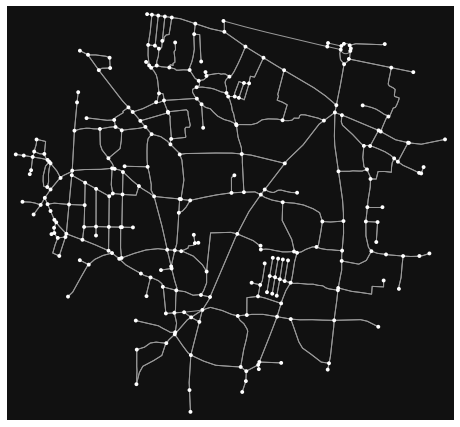

Number of nodes =  264
Number of edges =  678
Degree assortivity coefficient of the graph is  0.12168973238549799
Average clustering Coefficient =  0.05694444444444446
[ 53.   0.   0.  26.   0.   0. 158.   0.   0.  26.   0.   0.   1.]
[ 8. 18. 40. 49. 39. 36. 31. 19. 16.  8.]
[121.  35.  32.  19.  20.  12.   8.   7.   2.   1.   3.   2.   0.   0.
   2.]
[108.  60.  45.  32.  26.  15.  16.  11.  10.   8.   3.   5.   2.   0.
   1.   1.   0.   0.   1.]
[226.   5.   1.  26.   0.   0.   2.   0.   0.   4.]
[122.  34.  30.  20.  18.  15.   7.   8.   2.   1.   3.   2.   0.   0.
   2.]
[  1.   6.   0.   0.  18.   0.   0.   2.  14.  12.   0.  20.   2.   0.
 125.   0.   1.   7.  34.   3.   0.   8.   1.   0.   8.   0.   0.   2.]


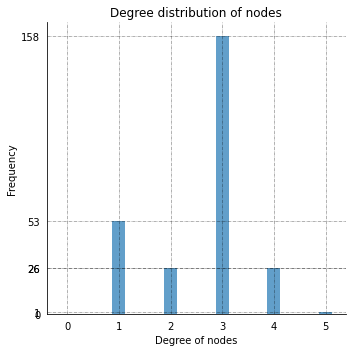

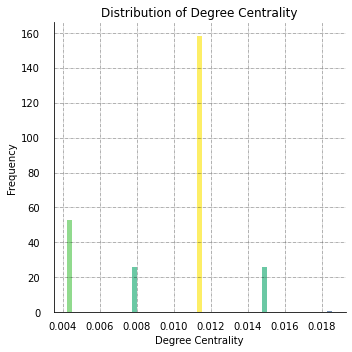

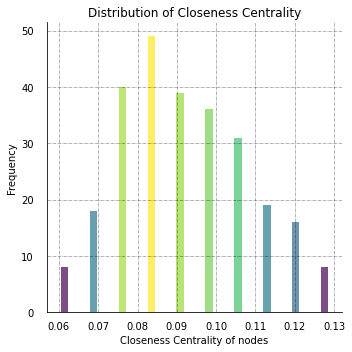

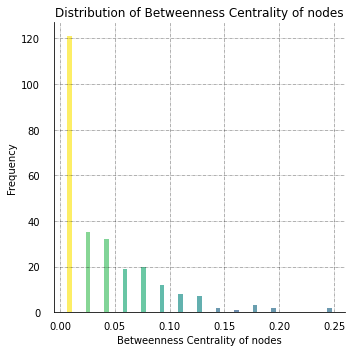

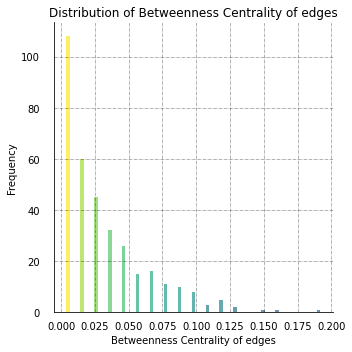

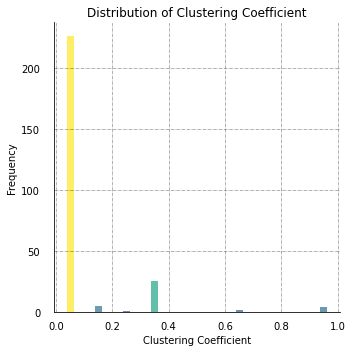

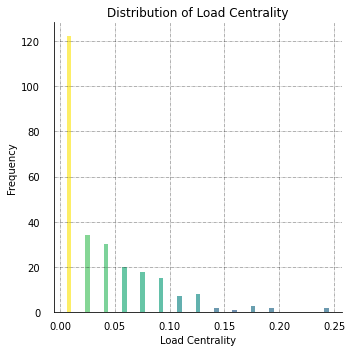

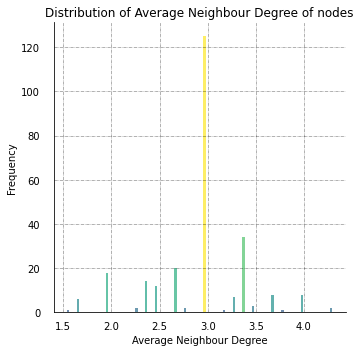

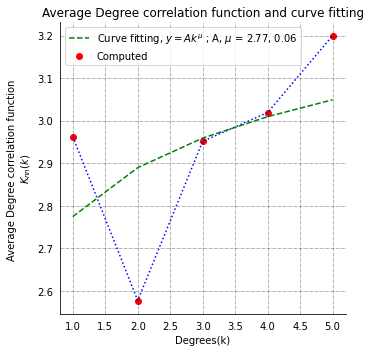

In [ ]:
file_name="ahemdabad_800m.graphml"
city_name="Ahemdabad"
distance="800 m"
city_network(file_name,city_name,distance)

Analysis for the city:bengaluru
Area covered within the distace of 850 m from the milepost of the city.


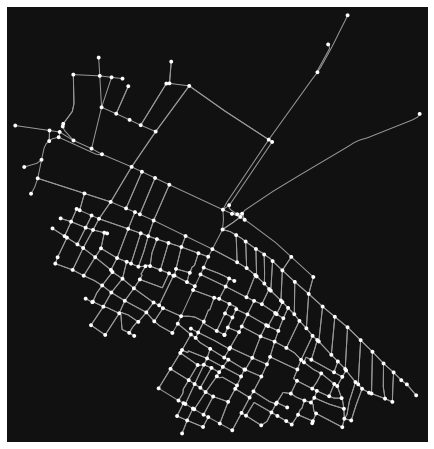

Number of nodes =  289
Number of edges =  773
Average clustering Coefficient =  0.01245674740484429
[ 22.   0.  28.   0. 190.   0.   0.  47.   0.   2.]
[ 2. 10. 22. 43. 35. 31. 31. 54. 46. 15.]
[101.  72.  21.  18.  17.  10.  13.   8.  13.   6.   1.   1.   2.   1.
   3.   2.]
[ 59. 126.  77.  32.  20.  14.  14.  11.  14.  12.  10.   6.   4.   5.
   5.   3.   3.   2.   2.   0.   0.   0.   0.   2.   0.   0.   1.   1.]
[277.   6.   0.   5.   0.   0.   0.   0.   0.   1.]
[108.  69.  22.  16.  15.  10.  15.   9.  12.   4.   1.   1.   2.   1.
   4.]
[  1.   0.   0.   0.   0.   8.   0.   0.  10.   0.   9.  15.   2.   0.
   0. 118.   0.  17.  57.   1.  22.   0.  16.   2.   0.   9.   0.   0.
   2.]


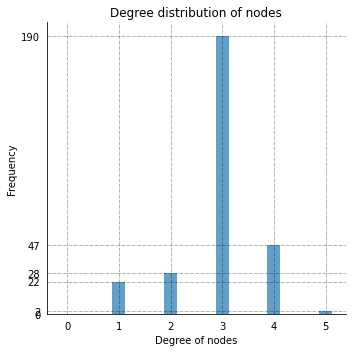

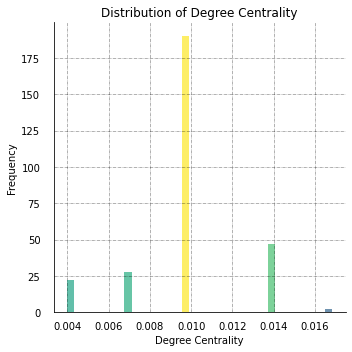

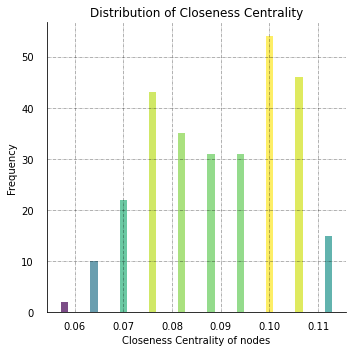

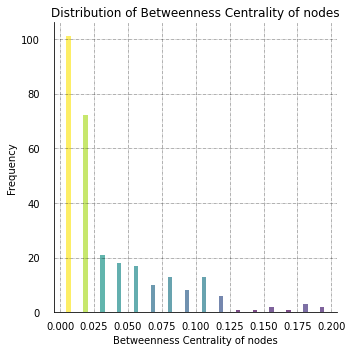

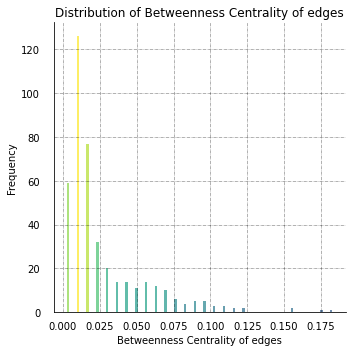

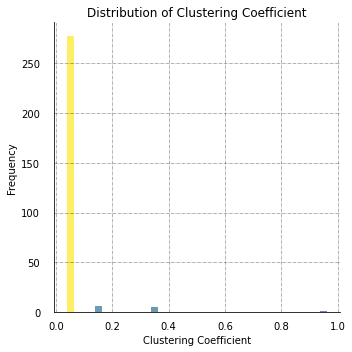

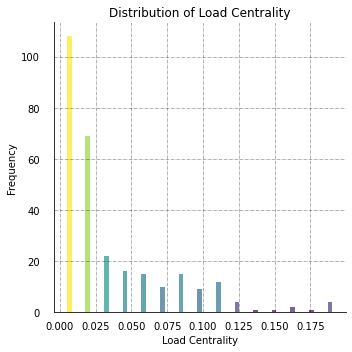

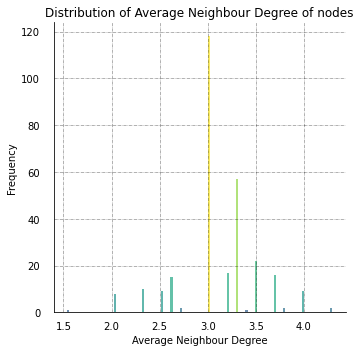

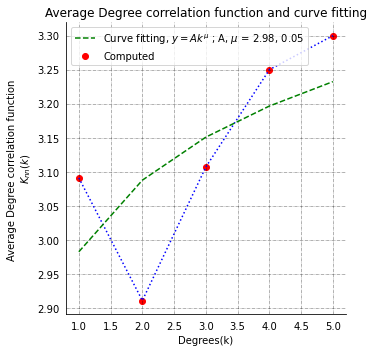

In [ ]:
file_name="bengaluru_850m.graphml"
city_name="bengaluru"
distance="850 m"
city_network(file_name,city_name,distance)

Analysis for the city:Bhopal
Area covered within the distace of 1400 m from the milepost of the city.


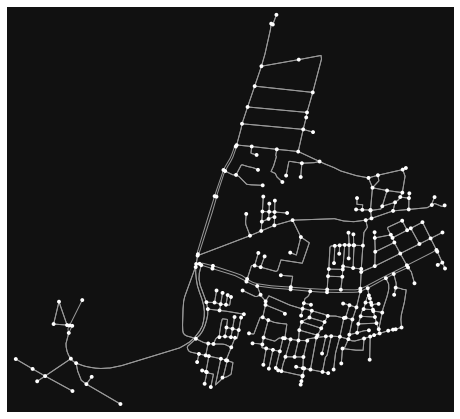

Number of nodes =  289
Number of edges =  701
Average clustering Coefficient =  0.02883506343713955
[ 71.   0.   0.  21.   0.   0. 173.   0.   0.  24.]
[ 3. 11. 32. 40. 52. 42. 35. 21. 20. 14. 12.  7.]
[129.  51.  26.  17.   8.  13.   7.   5.   9.   2.   2.   3.   2.   5.
   2.   1.   1.   2.   2.   0.   1.   0.   1.]
[136.  59.  43.  29.  14.  17.  13.   7.   5.   6.   3.   5.   4.   3.
   3.   2.   5.   1.   1.   2.   3.   1.   0.   2.]
[268.   4.   0.  14.   0.   0.   0.   0.   0.   3.]
[135.  52.  24.  12.  11.  13.   5.   6.   8.   1.   3.   2.   4.   4.
   2.   1.   1.   3.   0.   1.   0.   1.]
[  1.   2.   0.   5.   1.   0.  10.   0.   0.   4.  26.  12.   0.  22.
   2.   0. 136.   0.   0.   5.  39.   5.   0.   4.   0.   0.  15.]


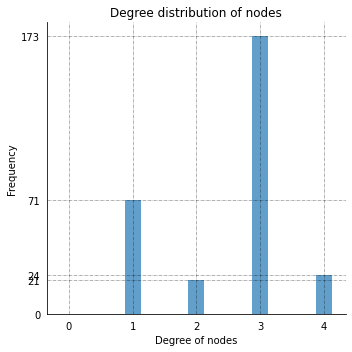

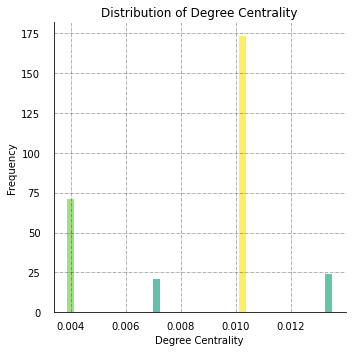

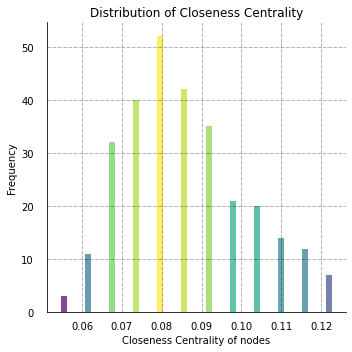

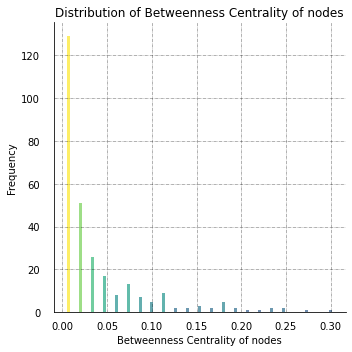

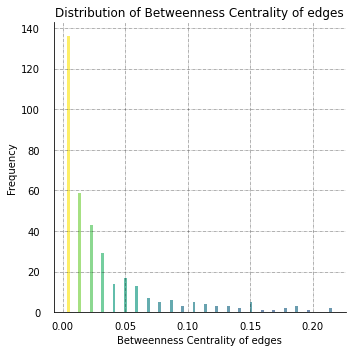

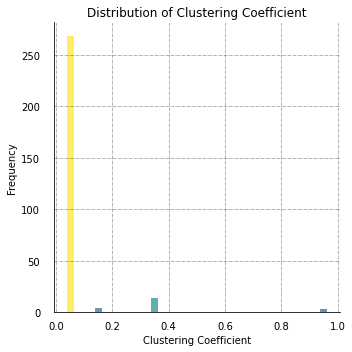

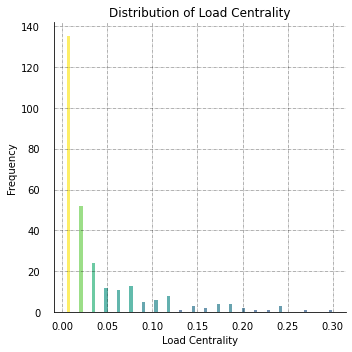

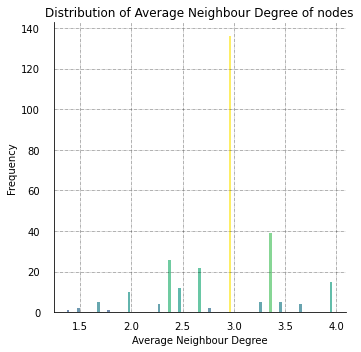

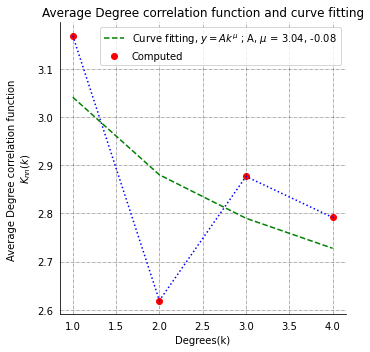

In [ ]:
file_name="bhopal_1o4km.graphml"
city_name="Bhopal"
distance="1400 m"
city_network(file_name,city_name,distance)

Analysis for the city:chennai
Area covered within the distace of 1500 m from the milepost of the city.


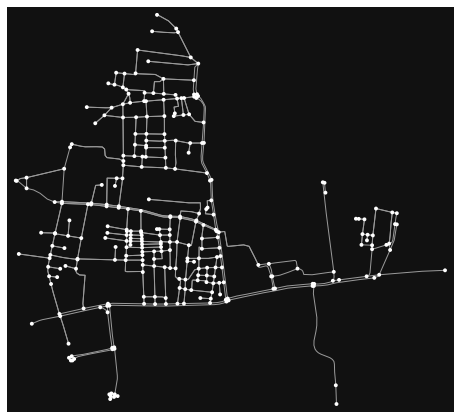

Number of nodes =  293
Number of edges =  706
Average clustering Coefficient =  0.037883959044368594
[ 42.   0.  23.   0.   0. 179.   0.  48.   0.   1.]
[ 2.  5.  7. 19. 35. 36. 48. 40. 45. 24. 12. 11.  6.  3.]
[104.  58.  41.  16.  16.  13.  12.   3.   3.   6.   5.   2.   2.   1.
   3.   1.   0.   0.   1.   0.   2.   1.   0.   1.   0.   1.   0.   0.
   0.   0.   0.   0.   0.   0.   1.]
[ 52. 135.  62.  40.  22.  14.  15.  11.  10.   9.   7.   7.   3.   0.
   3.   4.   0.   3.   2.   2.   1.   2.   2.   0.   0.   1.   0.   0.
   0.   1.   0.   1.   0.   0.   0.   0.   0.   0.   1.   1.]
[256.  15.   0.  20.   0.   0.   0.   0.   0.   2.]
[105.  63.  36.  16.  18.  13.  12.   1.   6.   6.   3.   1.   2.   2.
   1.   1.   0.   1.   0.   2.   1.   0.   1.   1.   0.   0.   0.   0.
   0.   0.   0.   0.   1.]
[  2.   0.   0.   0.   0.  10.   0.   2.  18.   0.  10.  20.   1.   0.
   0. 106.   0.  15.  60.   0.   9.  22.   3.   0.  15.]


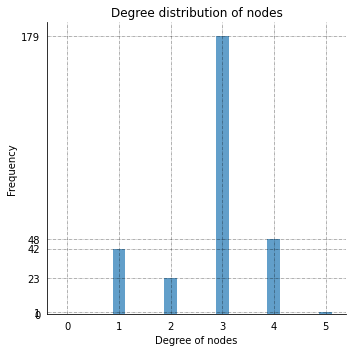

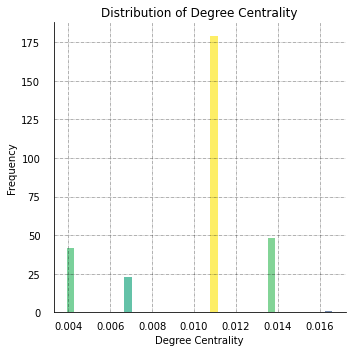

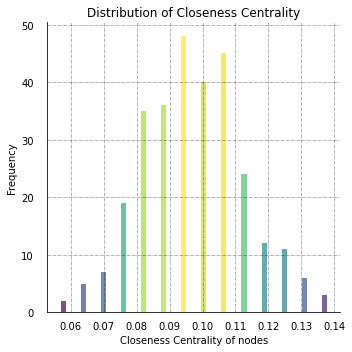

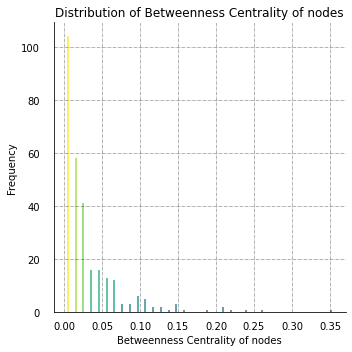

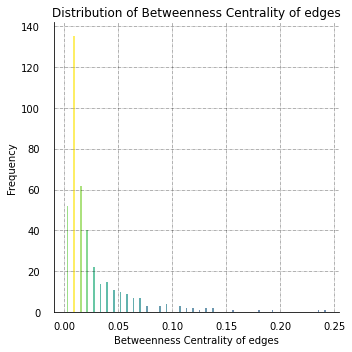

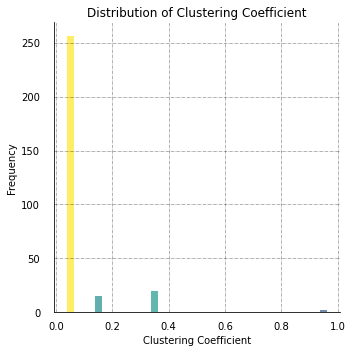

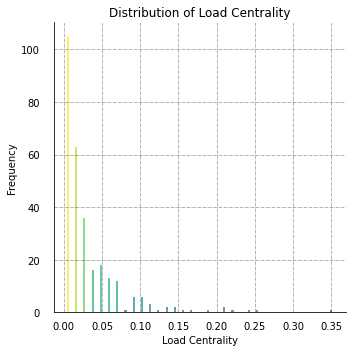

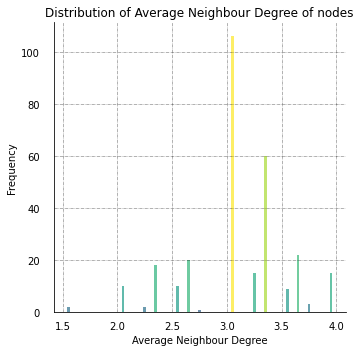

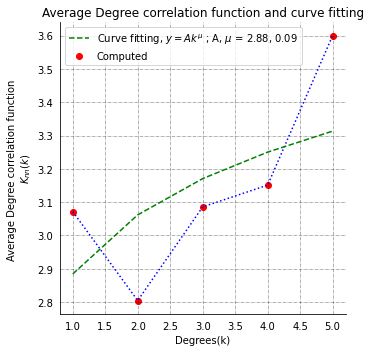

In [ ]:
file_name="chennai_1o5m.graphml"
city_name="chennai"
distance="1500 m"
city_network(file_name,city_name,distance)

Analysis for the city:Delhi
Area covered within the distace of 800 m from the milepost of the city.


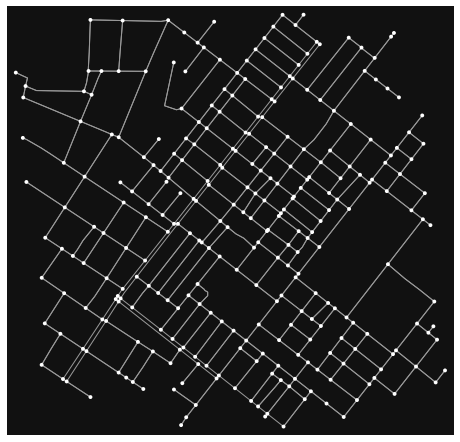

Number of nodes =  287
Number of edges =  792
Degree assortivity coefficient of the graph is  0.15988121452662954
Average clustering Coefficient =  0.002903600464576074
[ 23.   0.   0.  25.   0.   0. 185.   0.   0.  54.]
[ 4. 13. 30. 44. 39. 35. 48. 30. 26. 12.  6.]
[97. 59. 28. 29. 19. 17. 11.  5.  8.  3.  4.  2.  2.  0.  0.  1.  1.  0.
  0.  0.  0.  1.]
[135.  79.  62.  25.  25.  24.  14.  11.  14.   9.   3.   3.   1.   5.
   5.   1.   2.   0.   2.   0.   1.   0.   0.   0.   1.]
[284.   0.   0.   0.   0.   1.   0.   0.   0.   2.]
[99. 62. 23. 27. 18. 19. 12.  3.  9.  4.  3.  2.  3.  0.  0.  1.  1.  0.
  0.  0.  0.  1.]
[ 1.  0.  0.  0.  0. 13.  0.  1.  9.  0.  6. 16.  2.  0.  0. 96.  0. 20.
 65.  0. 20. 30.  3.  0.  5.]


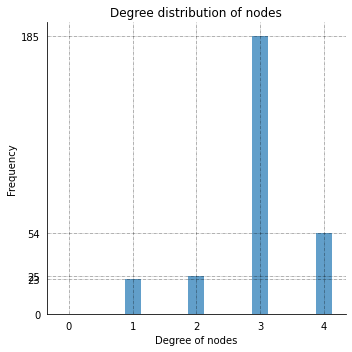

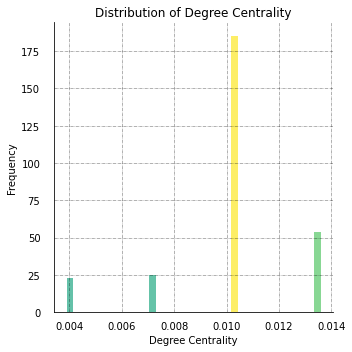

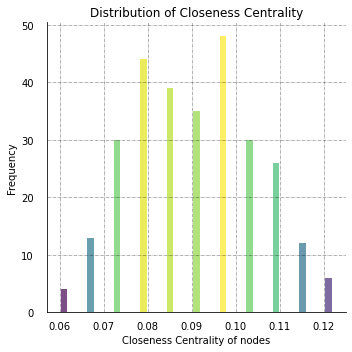

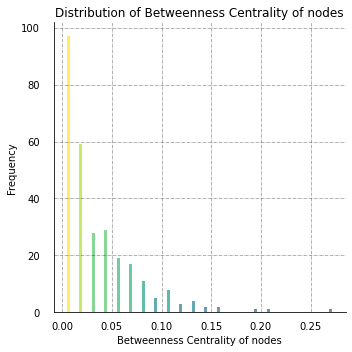

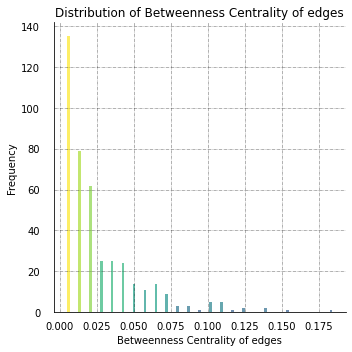

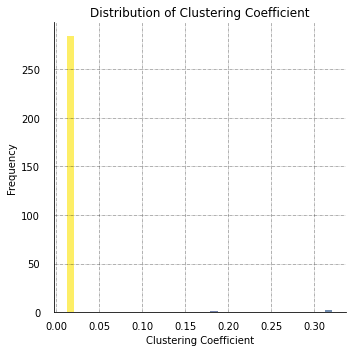

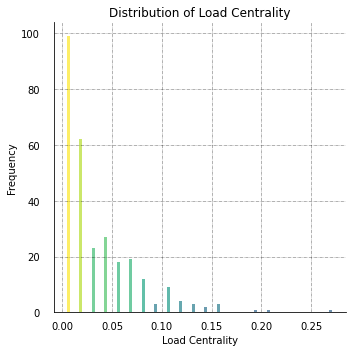

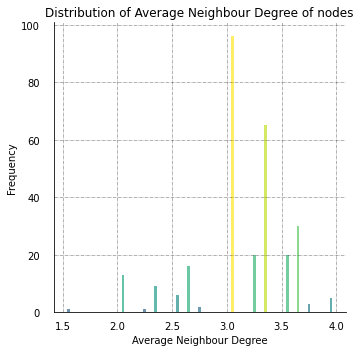

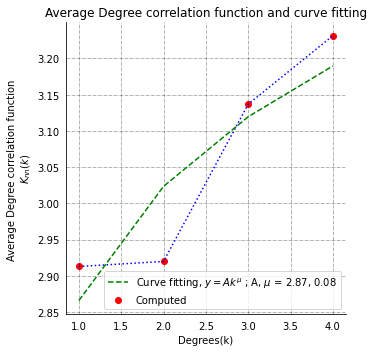

In [ ]:
file_name="delhi_800m.graphml"
city_name="Delhi"
distance="800 m"
city_network(file_name,city_name,distance)

Analysis for the city:Hydrabad
Area covered within the distace of 800 m from the milepost of the city.


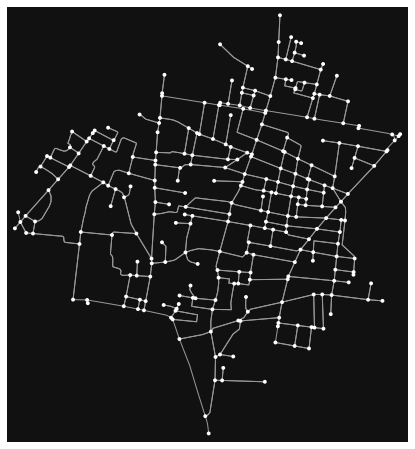

Number of nodes =  284
Number of edges =  738
Average clustering Coefficient =  0.02171361502347417
[ 48.   0.   0.  19.   0.   0. 186.   0.   0.  31.]
[ 3. 20. 40. 41. 40. 37. 41. 34. 21.  7.]
[114.  55.  22.  27.  19.  15.   9.   7.   1.   4.   6.   1.   0.   1.
   3.]
[117.  78.  53.  30.  21.  25.  16.  11.   6.   8.   4.   2.   3.   2.
   3.   3.   1.   0.   0.   0.   0.   0.   1.]
[263.   0.   0.   0.   0.   5.   0.   0.   0.  16.]
[114.  55.  24.  25.  19.  15.   7.   9.   1.   3.   7.   1.   0.   1.
   3.]
[  4.   0.   0.  14.   0.   0.  19.   0.   6.   0.  22.   3.   0. 132.
   0.   0.  11.  45.   7.   0.  12.   2.   0.   7.]


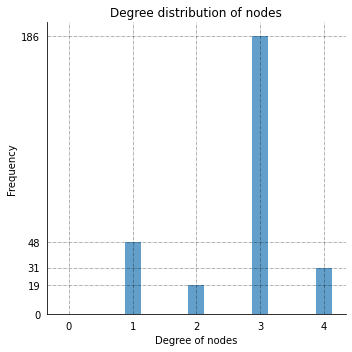

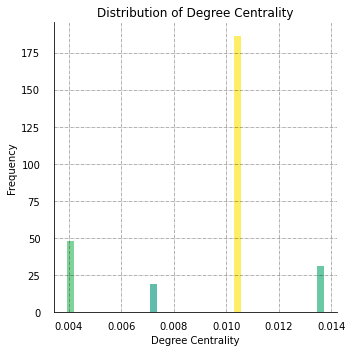

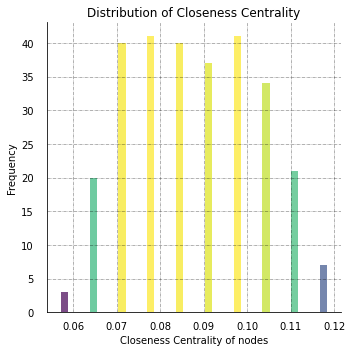

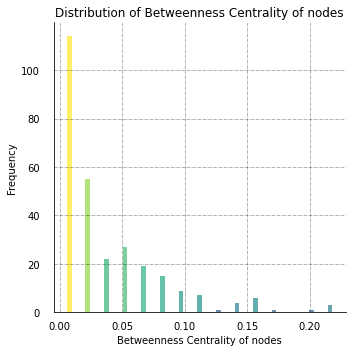

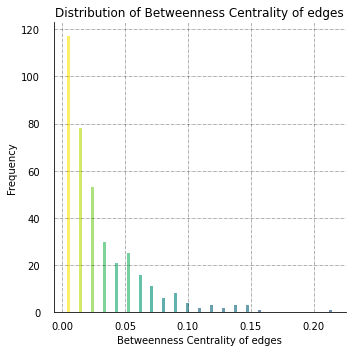

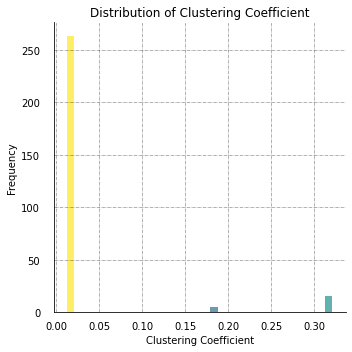

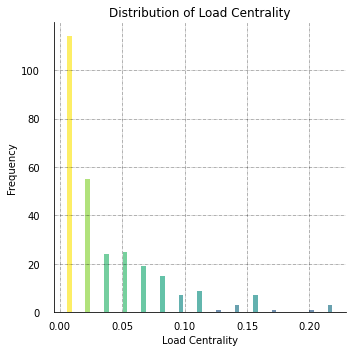

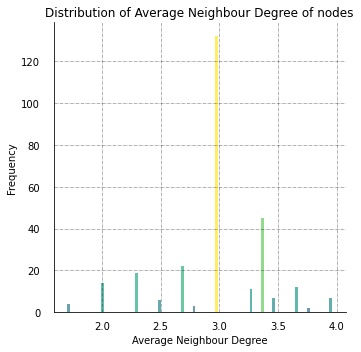

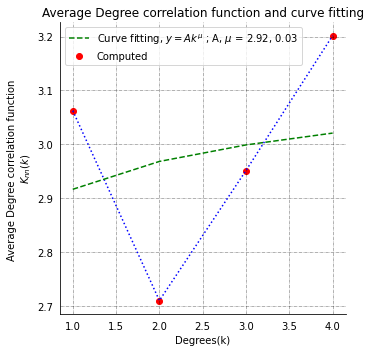

In [ ]:
file_name="hydrabad_800m.graphml"
city_name="Hydrabad"
distance="800 m"
city_network(file_name,city_name,distance)

Analysis for the city:Kolkata
Area covered within the distace of 2200 m from the milepost of the city.


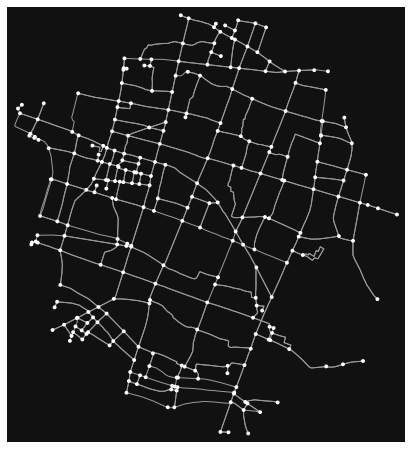

Number of nodes =  277
Number of edges =  738
Average clustering Coefficient =  0.028880866425992777
[ 29.   0.   0.  27.   0.   0. 167.   0.   0.  54.]
[16. 33. 30. 36. 35. 34. 29. 26. 17. 21.]
[101.  59.  27.  22.  17.   7.  14.   8.   5.   4.   4.   3.   3.   2.
   0.   0.   0.   0.   1.]
[98. 97. 64. 29. 21. 18. 17. 17. 10.  7.  2.  5.  6.  3.  2.  2.  1.  0.
  0.  1.]
[253.   8.   0.  14.   0.   0.   0.   0.   0.   2.]
[102.  58.  26.  23.  18.   6.  14.   8.   5.   4.   4.   4.   3.   1.
   0.   0.   0.   0.   1.]
[  2.   2.   0.   0.   0.  13.   0.   0.  10.   0.   7.  12.   5.   0.
   0. 102.   0.  18.  46.   0.  21.  25.   7.   0.   7.]


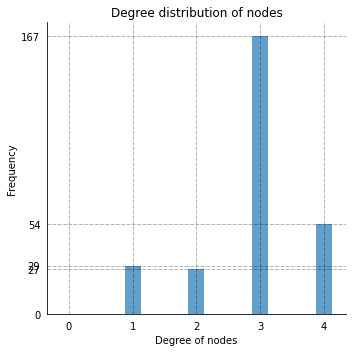

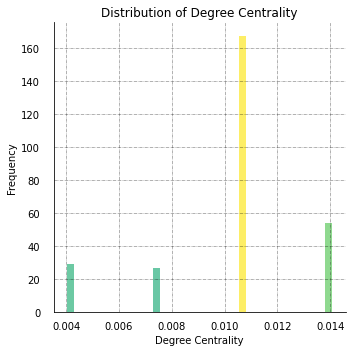

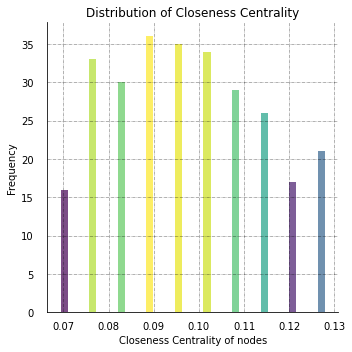

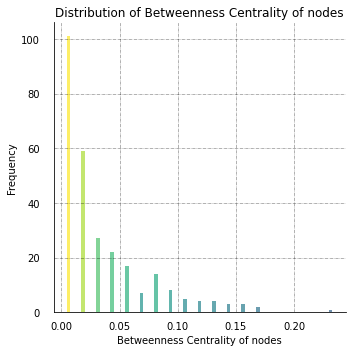

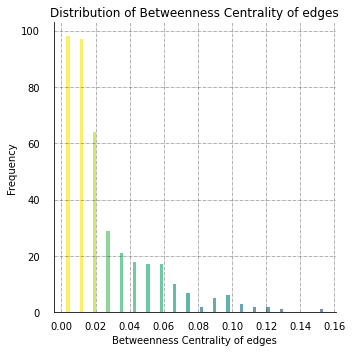

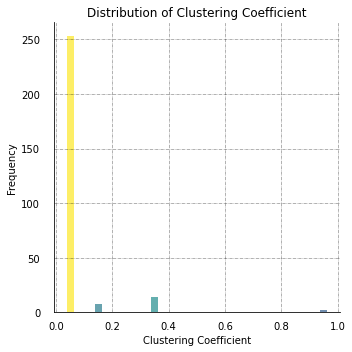

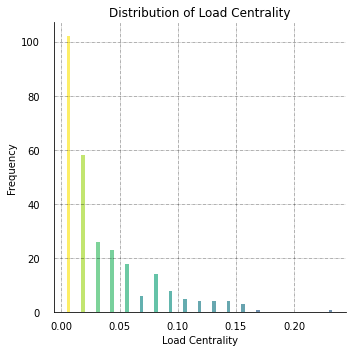

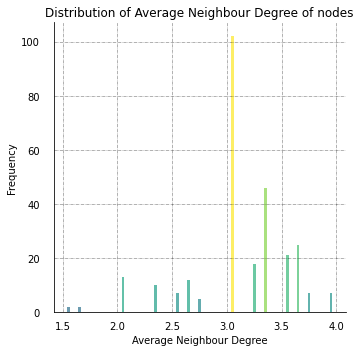

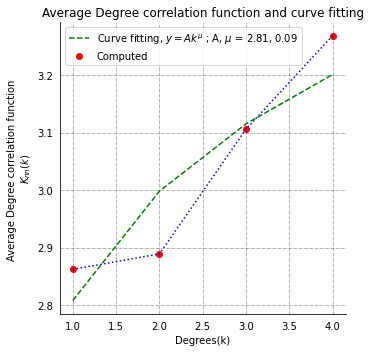

In [ ]:
file_name="kolkata_2o2km.graphml"
city_name="Kolkata"
distance="2200 m"
city_network(file_name,city_name,distance)

Analysis for the city:Mumbai
Area covered within the distace of 1300 m from the milepost of the city.


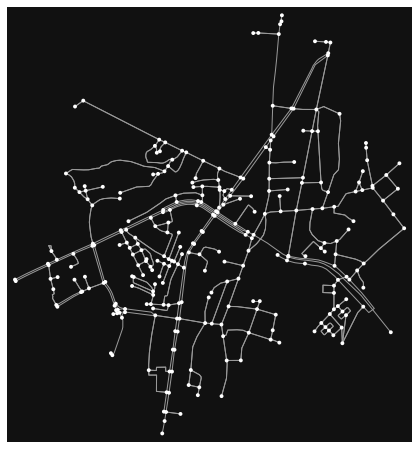

Number of nodes =  289
Number of edges =  635
Average clustering Coefficient =  0.048904267589388706
[ 66.   0.   0.  40.   0.   0. 148.   0.   0.   0.  33.   0.   0.   2.]
[10. 20. 32. 39. 45. 43. 37. 25. 20. 11.  7.]
[133.  46.  32.  19.  16.  14.  10.   4.   4.   1.   1.   1.   3.   2.
   1.   2.]
[120.  68.  44.  28.  29.  17.  13.  13.  11.   8.   4.   0.   0.   2.
   1.   2.   0.   1.   1.   0.   2.   1.   1.]
[245.  14.   1.  26.   0.   0.   0.   0.   0.   3.]
[133.  47.  32.  17.  17.  17.   8.   3.   4.   1.   1.   1.   3.   2.
   1.   2.]
[  4.   4.   0.  25.   0.  25.  17.  18.   4.   0. 120.   9.  29.   9.
   9.   1.  14.   0.   0.   1.]


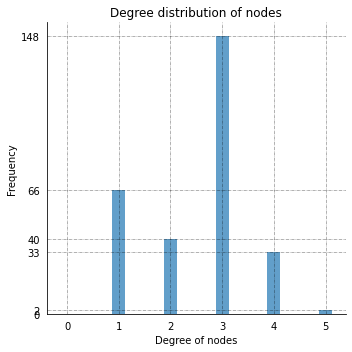

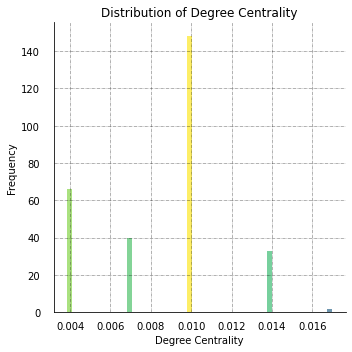

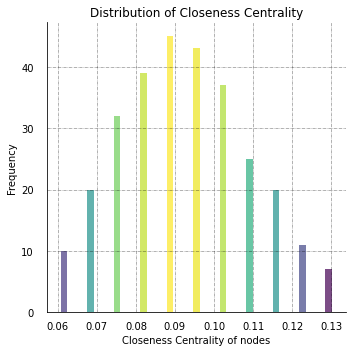

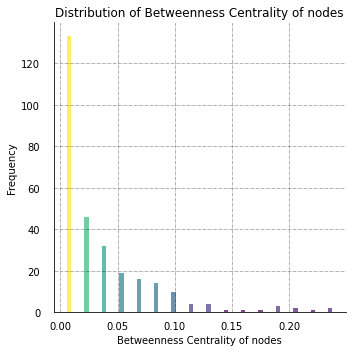

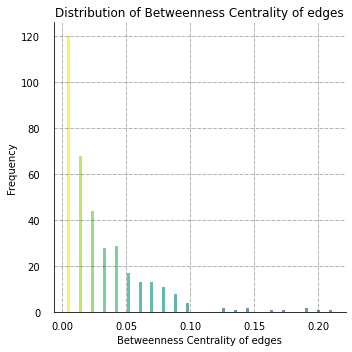

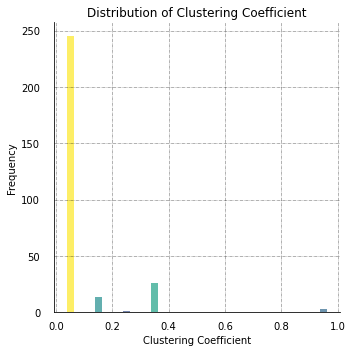

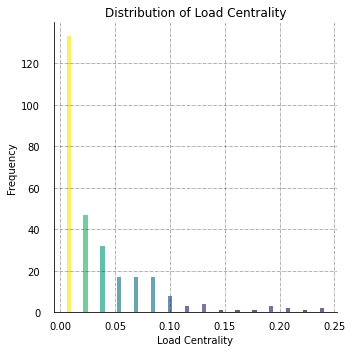

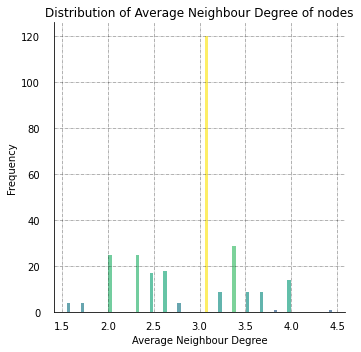

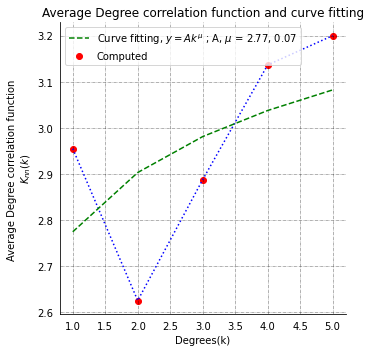

In [ ]:
file_name="mumbai_1o3km.graphml"
city_name="Mumbai"
distance="1300 m"
city_network(file_name,city_name,distance)

Analysis for the city:Pune
Area covered within the distace of 1500 m from the milepost of the city.


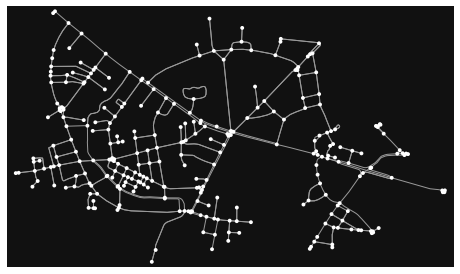

Number of nodes =  294
Number of edges =  638
Average clustering Coefficient =  0.04376417233560092
[ 58.   0.   0.  37.   0.   0.   0. 168.   0.   0.  29.   0.   0.   2.]
[ 8. 17. 22. 35. 39. 44. 38. 33. 30. 16. 12.]
[124.  48.  30.  26.  16.   7.   7.   7.   4.   1.   2.   0.   5.   0.
   0.   0.   0.   1.   1.   2.   1.   4.   0.   0.   0.   2.   2.   0.
   0.   2.   0.   1.   0.   0.   0.   0.   0.   1.]
[126.  79.  36.  32.  22.  15.  14.  10.   9.   4.   2.   3.   6.   1.
   0.   2.   2.   0.   1.   1.   0.   0.   1.   0.   0.   0.   2.   3.
   2.   0.   0.   0.   3.   0.   0.   0.   0.   1.   0.   1.   0.   0.
   0.   1.   1.   0.   1.]
[250.   0.   0.   2.   0.   8.   0.   0.   0.  34.]
[126.  47.  29.  25.  15.  10.   6.   7.   4.   1.   2.   1.   4.   0.
   0.   0.   0.   0.   3.   2.   0.   2.   2.   0.   0.   2.   2.   0.
   0.   2.   0.   1.   0.   0.   0.   0.   0.   1.]
[  1.   0.   5.   0.  15.   0.  27.  23.  28.   0. 117.   8.  40.   6.
  11.   0.  11.   2.]


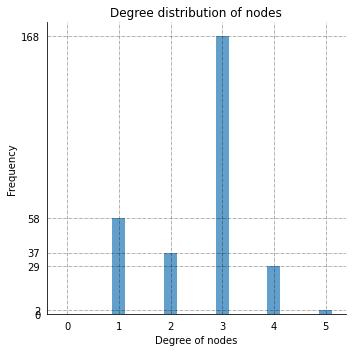

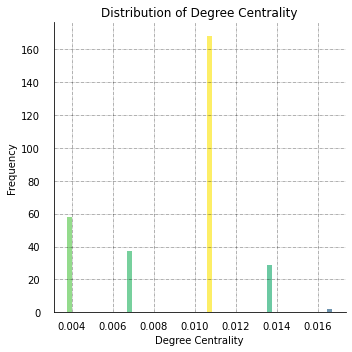

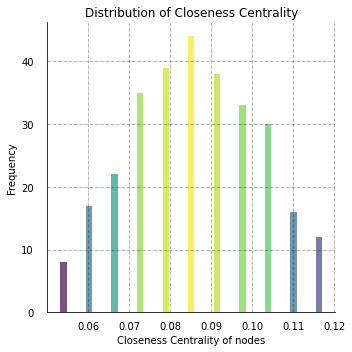

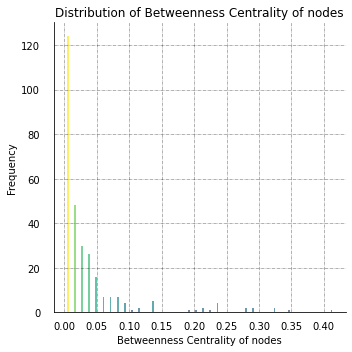

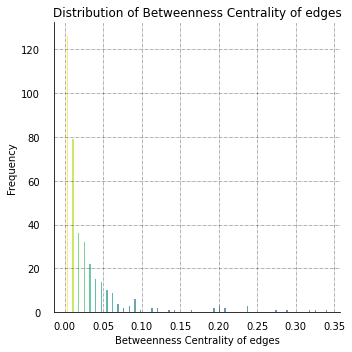

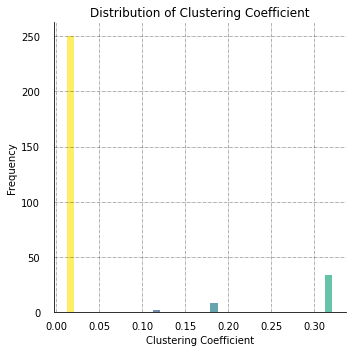

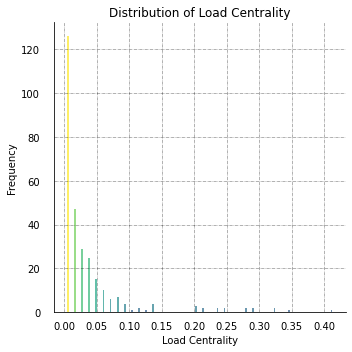

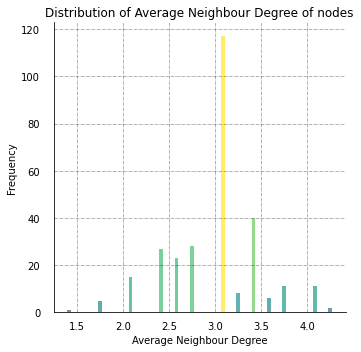

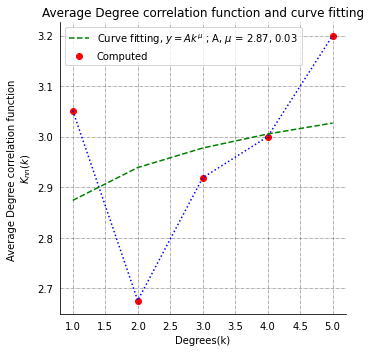

In [ ]:
file_name="pune_1o5km.graphml"
city_name="Pune"
distance="1500 m"
city_network(file_name,city_name,distance)

Analysis for the city:Roorkee
Area covered within the distace of 1600 m from the milepost of the city.


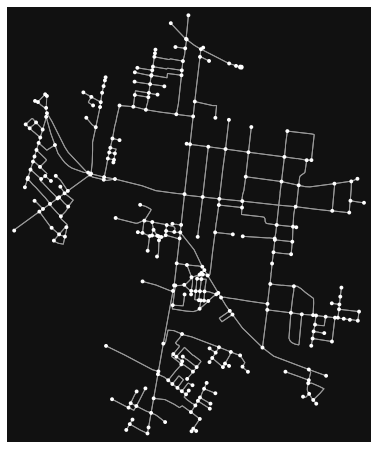

Number of nodes =  302
Number of edges =  748
Average clustering Coefficient =  0.05573951434878588
[ 75.   0.   0.  39.   0.   0.   0. 155.   0.   0.  33.]
[ 7. 24. 40. 52. 42. 43. 28. 25. 16. 12.  8.  5.]
[154.  40.  22.  20.  13.   8.   5.   4.   2.   5.   5.   1.   2.   1.
   4.   5.   0.   0.   1.   1.   1.   0.   1.   0.   0.   2.   2.   1.
   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.]
[155.  68.  33.  21.  12.  20.   9.   7.   6.   5.   2.   4.   2.   4.
   4.   2.   1.   1.   2.   2.   2.   1.   2.   1.   0.   0.   1.   2.
   0.   0.   0.   0.   1.   0.   0.   0.   2.   0.   1.   2.]
[251.  11.   0.  37.   0.   0.   1.   0.   0.   2.]
[155.  39.  22.  20.  14.   7.   5.   4.   2.   5.   5.   1.   2.   3.
   3.   4.   0.   0.   1.   1.   1.   0.   1.   0.   2.   0.   2.   1.
   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.]
[  2.   2.   0.   3.   0.   0.  19.   0.   0.   2.  28.  17.   0.  30.
   4.   0. 127.   0.   0.   3.  25.  13.   0.   

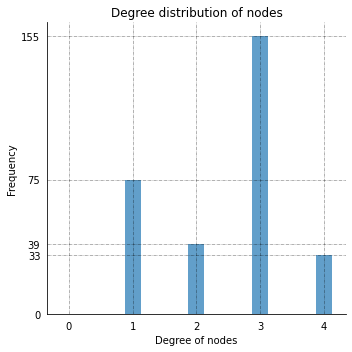

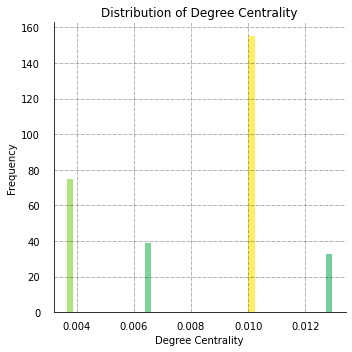

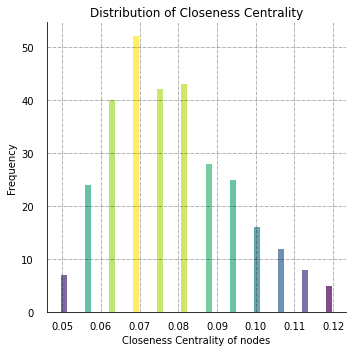

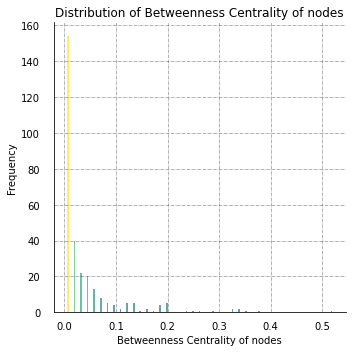

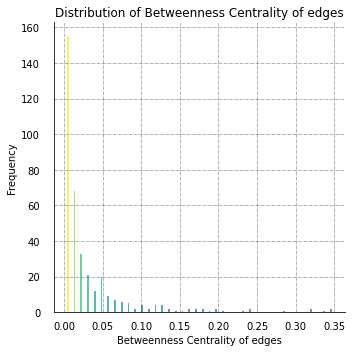

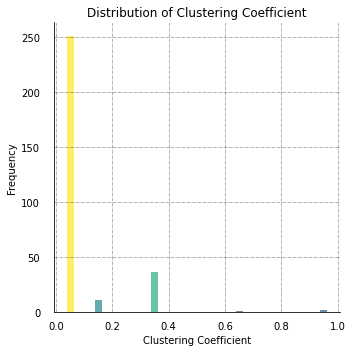

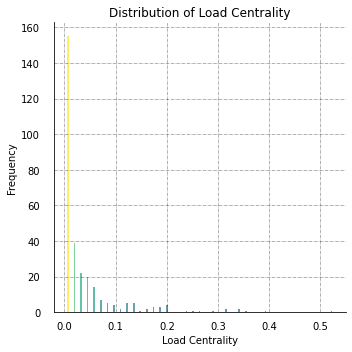

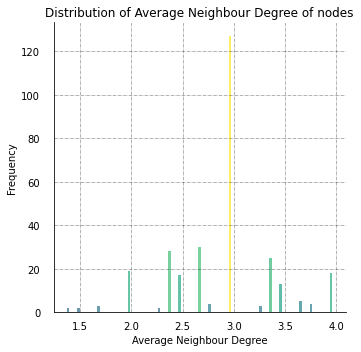

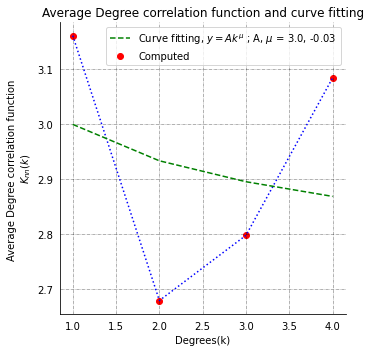

In [ ]:
file_name="roorkee_1o6km.graphml"
city_name="Roorkee"
distance="1600 m"
city_network(file_name,city_name,distance)

Average clustering Coefficient =  0.0
[ 32.   0.   0.   4.   0.   0.  76.   0.   0. 173.]
[52. 28. 28. 40. 40. 24. 24. 24. 16.  9.]
[60. 44. 28. 44. 24. 28. 24. 24.  5.  4.]
[88. 48. 48. 64. 72. 48. 72.  0. 12. 16.  4.  0.  4.  0.  0.  0.  0.  0.
  4.]
[285.]
[52. 60. 36. 44. 44. 16.  4. 24.  0.  5.]
[ 16.   0.   0.   0.   0.   0.  52.  40.   4.  48. 125.]


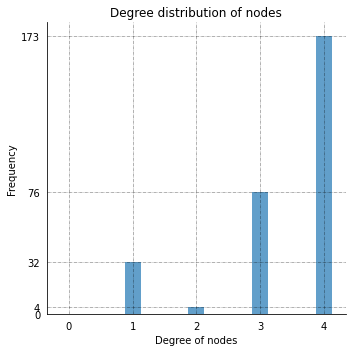

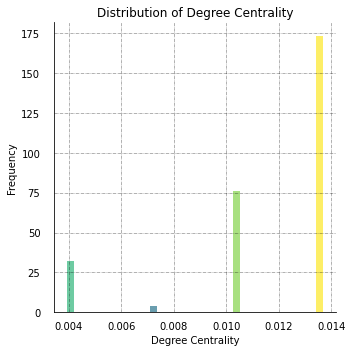

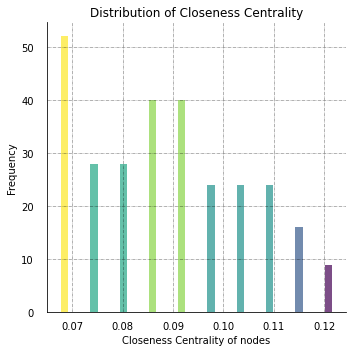

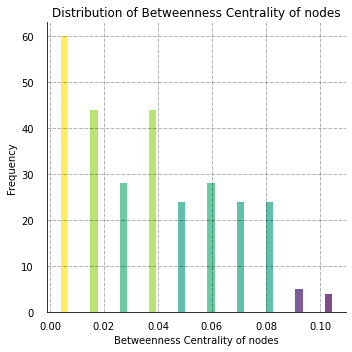

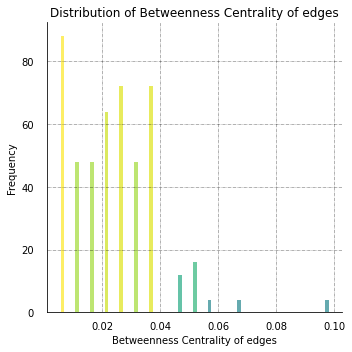

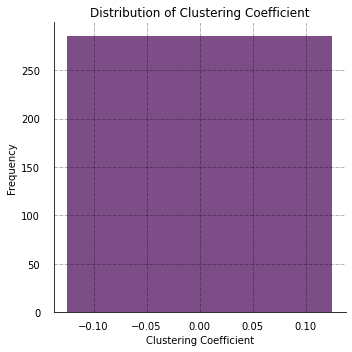

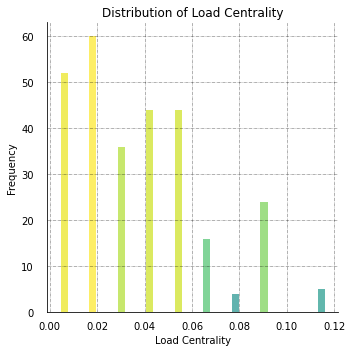

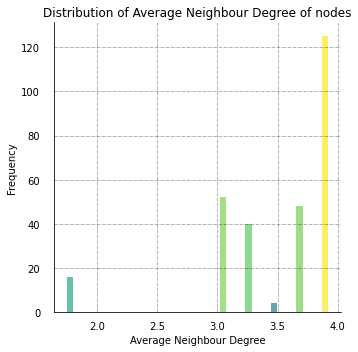

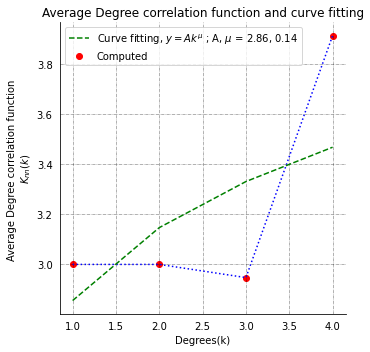

In [ ]:
calculation_graph(GT)

In [ ]:
#bangaluru 12.972442, 77.580643
#bhopal23.2599, 77.4126
#Hyderabad 17.387140, 78.491684
#pune 18.5204,73.8567
#kolkata 22.5726, 88.3639
#roorkee29.8543, 77.8880
#Chennai 13.0827, 80.2707
#Ahmedabad 23.033863,72.585022
'''location_point=(18.5204,73.8567)
arra=[]
for d in range(100,2000,50):
   G=ox.graph_from_point(location_point,dist=d,network_type="drive")
   n=G.number_of_nodes()
   arra.append([d,n])
   arra=np.array(arra)
'''
nx.degree_assortativity_coefficient(GT,weight=None, nodes=None)

0.541609822646655

In [ ]:
delhi=np.array([[  50,    2],
       [ 100,   16],
       [ 150,   29],
       [ 200,   56],
       [ 250,   86],
       [ 300,  112],
       [ 350,  147],
       [ 400,  170],
       [ 450,  213],
       [ 500,  252],
       [ 550,  294],
       [ 600,  345],
       [ 650,  408],
       [ 700,  465],
       [ 750,  537],
       [ 800,  598],
       [ 850,  675],
       [ 900,  715],
       [ 950,  771],
       [1000,  823],
       [1050,  885],
       [1100,  947],
       [1150, 1008],
       [1200, 1078],
       [1250, 1141],
       [1300, 1219],
       [1350, 1286],
       [1400, 1347],
       [1450, 1423],
       [1500, 1498],
       [1550, 1579],
       [1600, 1661],
       [1650, 1737],
       [1700, 1830],
       [1750, 1934],
       [1800, 2003],
       [1850, 2106],
       [1900, 2202],
       [1950, 2300]])
mumbai=np.array([[  50,    6],
       [ 100,    9],
       [ 150,   23],
       [ 200,   34],
       [ 250,   41],
       [ 300,   53],
       [ 350,   76],
       [ 400,   95],
       [ 450,  104],
       [ 500,  121],
       [ 550,  144],
       [ 600,  174],
       [ 650,  187],
       [ 700,  211],
       [ 750,  226],
       [ 800,  250],
       [ 850,  271],
       [ 900,  301],
       [ 950,  323],
       [1000,  363],
       [1050,  409],
       [1100,  430],
       [1150,  472],
       [1200,  502],
       [1250,  536],
       [1300,  555],
       [1350,  576],
       [1400,  599],
       [1450,  625],
       [1500,  653],
       [1550,  696],
       [1600,  734],
       [1650,  777],
       [1700,  833],
       [1750,  875],
       [1800,  978],
       [1850, 1021],
       [1900, 1077],
       [1950, 1111]])


bhopal=np.array([[50,0],[ 100,    4],
       [ 150,   11],
       [ 200,   21],
       [ 250,   24],
       [ 300,   41],
       [ 350,   68],
       [ 400,  128],
       [ 450,  243],
       [ 500,  302],
       [ 550,  344],
       [ 600,  438],
       [ 650,  527],
       [ 700,  618],
       [ 750,  685],
       [ 800,  784],
       [ 850,  846],
       [ 900,  923],
       [ 950,  997],
       [1000, 1087],
       [1050, 1193],
       [1100, 1310],
       [1150, 1435],
       [1200, 1555],
       [1250, 1718],
       [1300, 1889],
       [1350, 2042],
       [1400, 2181],
       [1450, 2333],
       [1500, 2494],
       [1550, 2629],
       [1600, 2771],
       [1650, 2928],
       [1700, 3113],
       [1750, 3290],
       [1800, 3472],
       [1850, 3652],
       [1900, 3915],
       [1950, 4134]])

bangaluru=np.array([[50,0],[ 100,   12],
       [ 150,   27],
       [ 200,   44],
       [ 250,   64],
       [ 300,   92],
       [ 350,  122],
       [ 400,  152],
       [ 450,  188],
       [ 500,  238],
       [ 550,  290],
       [ 600,  331],
       [ 650,  386],
       [ 700,  440],
       [ 750,  515],
       [ 800,  555],
       [ 850,  586],
       [ 900,  639],
       [ 950,  696],
       [1000,  741],
       [1050,  802],
       [1100,  855],
       [1150,  928],
       [1200,  964],
       [1250, 1027],
       [1300, 1085],
       [1350, 1157],
       [1400, 1236],
       [1450, 1309],
       [1500, 1390],
       [1550, 1485],
       [1600, 1562],
       [1650, 1653],
       [1700, 1767],
       [1750, 1866],
       [1800, 1988],
       [1850, 2109],
       [1900, 2229],
       [1950, 2372]])


Hyderabad=np.array([[50,0],[ 100,    8],
       [ 150,   21],
       [ 200,   57],
       [ 250,   82],
       [ 300,  118],
       [ 350,  164],
       [ 400,  221],
       [ 450,  271],
       [ 500,  314],
       [ 550,  373],
       [ 600,  424],
       [ 650,  483],
       [ 700,  536],
       [ 750,  572],
       [ 800,  604],
       [ 850,  645],
       [ 900,  716],
       [ 950,  911],
       [1000, 1019],
       [1050, 1104],
       [1100, 1220],
       [1150, 1376],
       [1200, 1533],
       [1250, 1732],
       [1300, 1885],
       [1350, 2065],
       [1400, 2241],
       [1450, 2433],
       [1500, 2588],
       [1550, 2804],
       [1600, 3012],
       [1650, 3203],
       [1700, 3419],
       [1750, 3627],
       [1800, 3821],
       [1850, 4004],
       [1900, 4214],
       [1950, 4416]])


pune=np.array([[  50,    3],
       [ 100,    9],
       [ 150,   21],
       [ 200,   38],
       [ 250,   63],
       [ 300,   78],
       [ 350,  117],
       [ 400,  154],
       [ 450,  173],
       [ 500,  209],
       [ 550,  254],
       [ 600,  286],
       [ 650,  326],
       [ 700,  373],
       [ 750,  422],
       [ 800,  477],
       [ 850,  520],
       [ 900,  583],
       [ 950,  612],
       [1000,  672],
       [1050,  717],
       [1100,  769],
       [1150,  842],
       [1200,  903],
       [1250,  966],
       [1300, 1046],
       [1350, 1104],
       [1400, 1186],
       [1450, 1261],
       [1500, 1329],
       [1550, 1413],
       [1600, 1502],
       [1650, 1582],
       [1700, 1686],
       [1750, 1771],
       [1800, 1869],
       [1850, 1969],
       [1900, 2060],
       [1950, 2150]])

kolkata=np.array([[50,0],[100,0],[150,0],[ 200, 2],
       [ 250,    2],
       [ 300,    5],
       [ 350,   12],
       [ 400,   15],
       [ 450,   17],
       [ 500,   24],
       [ 550,   30],
       [ 600,   41],
       [ 650,   52],
       [ 700,   61],
       [ 750,   73],
       [ 800,   85],
       [ 850,  101],
       [ 900,  114],
       [ 950,  120],
       [1000,  132],
       [1050,  147],
       [1100,  165],
       [1150,  179],
       [1200,  199],
       [1250,  214],
       [1300,  232],
       [1350,  270],
       [1400,  288],
       [1450,  319],
       [1500,  359],
       [1550,  382],
       [1600,  418],
       [1650,  446],
       [1700,  465],
       [1750,  483],
       [1800,  508],
       [1850,  536],
       [1900,  563],
       [1950,  600]])

roorkee=np.array([[  50,    2],
       [ 100,    5],
       [ 150,    9],
       [ 200,   14],
       [ 250,   23],
       [ 300,   31],
       [ 350,   40],
       [ 400,   43],
       [ 450,   55],
       [ 500,   62],
       [ 550,   74],
       [ 600,   82],
       [ 650,   93],
       [ 700,   96],
       [ 750,  100],
       [ 800,  114],
       [ 850,  132],
       [ 900,  149],
       [ 950,  189],
       [1000,  212],
       [1050,  238],
       [1100,  268],
       [1150,  305],
       [1200,  345],
       [1250,  425],
       [1300,  463],
       [1350,  511],
       [1400,  569],
       [1450,  657],
       [1500,  707],
       [1550,  759],
       [1600,  861],
       [1650,  952],
       [1700, 1012],
       [1750, 1108],
       [1800, 1172],
       [1850, 1250],
       [1900, 1304],
       [1950, 1353]])



Chennai=np.array([[  50,    4],
       [ 100,    9],
       [ 150,   19],
       [ 200,   37],
       [ 250,   49],
       [ 300,   68],
       [ 350,   78],
       [ 400,   83],
       [ 450,  101],
       [ 500,  116],
       [ 550,  129],
       [ 600,  159],
       [ 650,  187],
       [ 700,  217],
       [ 750,  316],
       [ 800,  356],
       [ 850,  400],
       [ 900,  451],
       [ 950,  505],
       [1000,  556],
       [1050,  598],
       [1100,  655],
       [1150,  701],
       [1200,  767],
       [1250,  815],
       [1300,  886],
       [1350,  978],
       [1400, 1038],
       [1450, 1109],
       [1500, 1194],
       [1550, 1284],
       [1600, 1379],
       [1650, 1490],
       [1700, 1602],
       [1750, 1715],
       [1800, 1852],
       [1850, 1947],
       [1900, 2051],
       [1950, 2159]])


Ahmedabad=np.array([[  50,    3],
       [ 100,    5],
       [ 150,   10],
       [ 200,   15],
       [ 250,   31],
       [ 300,   60],
       [ 350,   90],
       [ 400,  118],
       [ 450,  162],
       [ 500,  203],
       [ 550,  245],
       [ 600,  301],
       [ 650,  364],
       [ 700,  435],
       [ 750,  494],
       [ 800,  542],
       [ 850,  601],
       [ 900,  646],
       [ 950,  676],
       [1000,  715],
       [1050,  765],
       [1100,  811],
       [1150,  844],
       [1200,  890],
       [1250,  959],
       [1300, 1021],
       [1350, 1059],
       [1400, 1124],
       [1450, 1182],
       [1500, 1265],
       [1550, 1328],
       [1600, 1378],
       [1650, 1446],
       [1700, 1520],
       [1750, 1591],
       [1800, 1669],
       [1850, 1782],
       [1900, 1854],
       [1950, 1948]])

Text(0.5, 0, 'radial distance from milepost point of a city(m)')

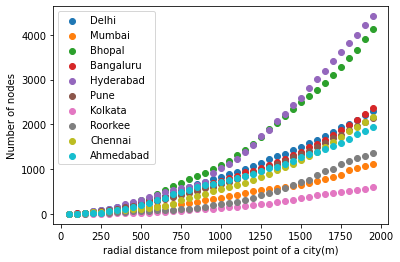

In [ ]:
#plt.plot(delhi[::,0],delhi[::,1],ls=":",color='red')
plt.scatter(delhi[::,0],delhi[::,1],label="Delhi")
#plt.plot(mumbai[::,0],mumbai[::,1],ls=":",color='green')
plt.scatter(mumbai[::,0],mumbai[::,1],label="Mumbai")
#plt.plot(bhopal[::,0],bhopal[::,1],ls=":",color='red')
plt.scatter(bhopal[::,0],bhopal[::,1],label="Bhopal")
plt.scatter(bangaluru[::,0],bangaluru[::,1],label="Bangaluru")
plt.scatter(Hyderabad[::,0],Hyderabad[::,1],label="Hyderabad")
plt.scatter(pune[::,0],pune[::,1],label="Pune")
plt.scatter(kolkata[::,0],kolkata[::,1],label="Kolkata")
plt.scatter(roorkee[::,0],roorkee[::,1],label="Roorkee")
plt.scatter(Chennai[::,0],Chennai[::,1],label="Chennai")
plt.scatter(Ahmedabad[::,0],Ahmedabad[::,1],label="Ahmedabad")
plt.legend()
plt.ylabel("Number of nodes")
plt.xlabel("radial distance from milepost point of a city(m)")

In [ ]:
deg_correlation_funct=deg_correlation_funct(G)
mat_nodes_same_degree=mat_cont_same_deg_nodes(G)
avg_Dcorr_fun1=average_degree_correlation_fun(deg_correlation_funct,G,mat_nodes_same_degree)
r1= nx.degree_assortativity_coefficient(G)

60

In [ ]:
Curve_fitting_plotting(avg_Dcorr_fun,"Average Degree correlation \n function for GT model")